# 点击率预估

点击率预估用来判断一条广告被用户点击的概率，对每次广告的点击做出预测，把用户最有可能点击的广告找出来，是广告技术最重要的算法之一。

## 数据集下载

<img src="criteo.jpg"\>
这次我们使用Kaggle上的[`Display Advertising Challenge`](https://www.kaggle.com/c/criteo-display-ad-challenge/)挑战的criteo数据集。

下载数据集请在终端输入下面命令(脚本文件路径：./data/download.sh)：

wget --no-check-certificate https://s3-eu-west-1.amazonaws.com/criteo-labs/dac.tar.gz

tar zxf dac.tar.gz

rm -f dac.tar.gz

mkdir raw

mv ./*.txt raw/


解压缩以后，train.txt文件11.7G，test.txt文件1.35G。

数据量太大了，我们只使用前100万条数据。

head -n 1000000 test.txt > test_sub100w.txt

head -n 1000000 train.txt > train_sub100w.txt

然后将文件名重新命名为train.txt和test.txt，文件位置不变。

### Data fields

#### Label 
- Target variable that indicates if an ad was clicked (1) or not (0).

#### I1-I13 
- A total of 13 columns of integer features (mostly count features).

#### C1-C26 
- A total of 26 columns of categorical features. The values of these features have been hashed onto 32 bits for anonymization purposes. 

数据中含有Label字段，表示这条广告是否被点击，I1-I13一共13个数值特征（Dense Input），C1-C26共26个Categorical类别特征（Sparse Input）。

## 网络模型

<img src='model.png'\>

模型包含三部分网络，一个是FFM(Field-aware Factorization Machines)，一个是FM(Factorization Machine)，另一个是DNN，其中FM网络包含GBDT和FM两个组件。通常在数据预处理的部分，需要做特征交叉组合等特征工程，以便找出帮助我们预测的特征出来，这绝对是技术活。

这次我们跳过特征工程的步骤，把这些组件和深度神经网络组合在一起，将挑选特征的工作交给模型来处理。其中FFM使用了[`LibFFM`](https://www.csie.ntu.edu.tw/~cjlin/libffm/)，FM使用了[`LibFM`](http://www.libfm.org)，GBDT使用了[`LightGBM`](https://github.com/Microsoft/LightGBM)，当然你也可以使用[`xgboost`](http://xgboost.readthedocs.io/en/latest/)。

### GBDT

给入训练数据后，GBDT会训练出若干棵树，我们要使用的是GBDT中每棵树输出的叶子结点，将这些叶子结点作为categorical类别特征输入给FM。有关决策树的使用，请参照Facebook的这篇文章[`Practical Lessons from Predicting Clicks on Ads at Facebook`](http://quinonero.net/Publications/predicting-clicks-facebook.pdf)。
<img src="facebook.png"\>

### FM

FM用来解决数据量大并且特征稀疏下的特征组合问题，先来看看公式（只考虑二阶多项式的情况）：n代表样本的特征数量，$x_i$是第i个特征的值，$w_0$、$w_i$、$w_i$$_j$是模型参数。
<img src="fm_formula.png"\>

从公式可以看出来这是在线性模型基础上，添加了特征组合$x_ix_j$，当然只有在特征$x_i$和$x_j$都不为0时才有意义。然而在实际的应用场景中，训练组合特征的参数是很困难的。因为输入数据普遍存在稀疏性，这导致$x_i$和$x_j$大部分情况都是0，而组合特征的参数$w_i$$_j$只有在特征不为0时才能训练出有意义的值。

比如跟购物相关的特征中，女性可能会更关注化妆品或者首饰之类的物品，而男性可能更关注体育用品或者电子产品等商品，这说明特征组合训练是有意义的。而商品特征可能存在几百上千种分类，通常我们将类别特征转成One hot编码的形式，这样一个特征就要变成几百维的特征，再加上其他的分类特征，这导致输入的特征空间急剧膨胀，所以数据的稀疏性是实际问题中不可避免的挑战。

为了解决二次项参数训练的问题，引入了矩阵分解的概念。在上一篇文章中我们讨论的是电影推荐系统，我们构造了用户特征向量和电影特征向量，通过两个特征向量的点积得到了用户对于某部电影的评分。如果将用户特征矩阵与电影特征矩阵相乘就会得到所有用户对所有影片的评分矩阵。

如果将上面的过程反过来看，实际上对于评分矩阵，我们可以分解成用户矩阵和电影矩阵，而评分矩阵中每一个数据点就相当于上面讨论的组合特征的参数$w_i$$_j$。

对于参数矩阵W，我们采用矩阵分解的方法，将每一个参数$w_i$$_j$分解成两个向量（称之为隐向量）的点积。这样矩阵就可以分解为$W=V^TV$，而每个参数$w_i$$_j$=⟨$v_i$,$v_j$⟩，$v_i$是第i维特征的隐向量，这样FM的二阶公式就变成：
<img src="fm_formula2.png"\>

这就是FM模型的思想。

将GBDT输出的叶子节点作为训练数据的输入，来训练FM模型。这样对于我们的FM网络，需要训练GBDT和FM。看得出来，这次我们的点击率预测网络要复杂了许多，影响最终结果的因素和超参更多了。关于FM和GBDT两个组件的训练我们会在下文进行说明。

### FFM

接下来需要训练FFM模型。FFM在FM的基础上增加了一个Field的概念，比如说一个商品字段，是一个分类特征，可以分成很多不同的feature，但是这些feature都属于同一个Field，或者说同一个categorical的分类特征都可以放到同一个Field。

这可以看成是1对多的关系，打个比方，比如职业字段，这是一个特征，经过One Hot以后，变成了N个特征。那这N个特征其实都属于职业，所以职业就是一个Field。

我们要通过特征组合来训练隐向量，这样每一维特征$x_i$，都会与其他特征的每一种Field $f_j$学习一个隐向量$v_{i,f_j}$。也就是说，隐向量不仅与特征有关，还与Field有关。模型的公式：
<img src="ffm_formula.png"\>

### DNN

我们来看DNN的部分。将输入数据分成两部分，一部分是数值特征（Dense Input），一部分是类别特征（Sparse Input）。我们仍然不适用One Hot编码，将类别特征传入嵌入层，得到多个嵌入向量，再将这些嵌入向量和数值特征连接在一起，传入全连接层，一共连接三层全连接层，使用Relu激活函数。然后再将第三层全连接的输出和FFM、FM的全连接层的输出连接在一起，传入最后一层全连接层。

我们要学习的目标Label表示广告是否被点击了，只有1（点击）和0（没有点击）两种状态。所以我们网络的最后一层要做Logistic回归，在最后一层全连接层使用Sigmoid激活函数，得到广告被点击的概率。

使用LogLoss作为损失函数，FTRL作为学习算法。

FTRL有关的Paper：[`Ad_click_prediction_a_view_from_the_trenches`](https://www.researchgate.net/publication/262412214_Ad_click_prediction_a_view_from_the_trenches)

#### LibFFM和LibFM的代码我做了修改，请使用代码库中我的相关代码。

## 预处理数据集

- 生成神经网络的输入
- 生成FFM的输入
- 生成GBDT的输入

首先要为DNN、FFM和GBDT的输入做预处理。对于数值特征，我们将I1-I13转成0-1之间的小数。类别特征我们将某类别使用次数少于cutoff（超参）的忽略掉，留下使用次数多的feature作为某类别字段的特征，然后将这些特征以各自字段为组进行编号。

比如有C1和C2两个类别字段，C1下面有特征a（大于cutoff次）、b（少于cutoff次）、c（大于cutoff次），C2下面有特征x和y（均大于cutoff次），这样留下来的特征就是C1：a、c和C2：x、y。然后以各自字段为分组进行编号，对于C1字段，a和c的特征id对应0和1；对于C2字段，x和y也是0和1。

对于类别特征的输入数据处理，FFM和GBDT各不相同，我们分别来说。

### GBDT

GBDT的处理要简单一些，C1-C26每个字段各自的特征id值作为输入即可。
GBDT的输入数据格式是：Label I1-I13 C1-C26
所以实际输入可能是这样：0 小数1 小数2 ~ 小数13 1（C1特征Id） 0（C2特征Id） ~ C26特征Id
其中C1特征Id是1，说明此处C1字段的feature是c，而C2字段的feature是x。

下面是一段生成的真实数据：
0	0.05	0.004983	0.05	0	0.021594	0.008	0.15	0.04	0.362	0.166667	0.2	0	0.04	2	3	0	0	1	1	0	3	1	0	0	0	0	3	0	0	1	4	1	3	0	0	2	0	1	0

很抱歉，我的造句能力实在很差，要是上面一段文字看的你很混乱的话，那就直接看代码吧：）

### FFM

FFM的输入数据要复杂一些，详细可以参看官方[`Github`](https://github.com/guestwalk/libffm)上的说明，摘抄如下：

It is important to understand the difference between `field` and `feature`. For example, if we have a raw data like this:

    Click  Advertiser  Publisher
    =====  ==========  =========
    0        Nike        CNN
    1        ESPN        BBC

Here, we have 

    * 2 fields: Advertiser and Publisher
    * 4 features: Advertiser-Nike, Advertiser-ESPN, Publisher-CNN, Publisher-BBC

Usually you will need to build two dictionares, one for field and one for features, like this:
    
    DictField[Advertiser] -> 0
    DictField[Publisher]  -> 1
    
    DictFeature[Advertiser-Nike] -> 0
    DictFeature[Publisher-CNN]   -> 1
    DictFeature[Advertiser-ESPN] -> 2
    DictFeature[Publisher-BBC]   -> 3

Then, you can generate FFM format data:

    0 0:0:1 1:1:1
    1 0:2:1 1:3:1

Note that because these features are categorical, the values here are all ones.


fields应该很好理解，features的划分跟之前GBDT有些不一样，在刚刚GBDT的处理中我们是每个类别内独立编号，C1有features 0~n，C2有features 0~n。而这次FFM是所有的features统一起来编号。你看它的例子，C1是Advertiser，有两个feature，C2是Publisher，有两个feature，统一起来编号就是0~3。而在GBDT我们要独立编号的，看起来像这样：

    DictFeature[Advertiser-Nike] -> 0
    DictFeature[Advertiser-ESPN] -> 1
    DictFeature[Publisher-CNN]   -> 0
    DictFeature[Publisher-BBC]   -> 1 
现在我们假设有第三条数据，看看如何构造FFM的输入数据：

    Click  Advertiser  Publisher
    =====  ==========  =========
    0        Nike        CNN
    1        ESPN        BBC
    0        Lining      CNN

按照规则，应该是像下面这样：

    DictFeature[Advertiser-Nike]   -> 0
    DictFeature[Publisher-CNN]     -> 1
    DictFeature[Advertiser-ESPN]   -> 2
    DictFeature[Publisher-BBC]     -> 3
    DictFeature[Advertiser-Lining] -> 4
在我们这次FFM的输入数据处理中，跟上面略有些区别，每个类别编号以后，下一个类别继续编号，所以最终的features编号是这样的：

    DictFeature[Advertiser-Nike]   -> 0
    DictFeature[Advertiser-ESPN]   -> 1
    DictFeature[Advertiser-Lining] -> 2
    DictFeature[Publisher-CNN]     -> 3
    DictFeature[Publisher-BBC]     -> 4

对于我们的数据是从I1开始编号的，从I1-I13，所以C1的编号要从加13开始。

这是一条来自真实的FFM输入数据：
0	0:0:0.05	1:1:0.004983	2:2:0.05	3:3:0	4:4:0.021594	5:5:0.008	6:6:0.15	7:7:0.04	8:8:0.362	9:9:0.166667	10:10:0.2	11:11:0	12:12:0.04	13:15:1	14:29:1	15:64:1	16:76:1	17:92:1	18:101:1	19:107:1	20:122:1	21:131:1	22:133:1	23:143:1	24:166:1	25:179:1	26:209:1	27:216:1	28:243:1	29:260:1	30:273:1	31:310:1	32:317:1	33:318:1	34:333:1	35:340:1	36:348:1	37:368:1	38:381:1

### DNN

DNN的输入数据就没有那么复杂了，仍然是I1-I13的小数和C1-C26的统一编号，就像FFM一样，只是不需要从加13开始，最后是Label。
真实数据就像这样：
0.05,0.004983,0.05,0,0.021594,0.008,0.15,0.04,0.362,0.166667,0.2,0,0.04,2,16,51,63,79,88,94,109,118,120,130,153,166,196,203,230,247,260,297,304,305,320,
327,335,355,368,0

要说明的就这么多了，我们来看看代码吧，因为要同时生成训练数据、验证数据和测试数据，所以要运行一段时间。

In [2]:
import os
import sys
import click
import random
import collections

import numpy as np
import lightgbm as lgb
import json
import lightgbm as lgb
import pandas as pd
from sklearn.metrics import mean_squared_error


In [3]:
import pickle

def save_params(params):
    """
    Save parameters to file
    """
    pickle.dump(params, open('params.p', 'wb'))


def load_params():
    """
    Load parameters from file
    """
    return pickle.load(open('params.p', mode='rb'))


def save_params_with_name(params, name):
    """
    Save parameters to file
    """
    pickle.dump(params, open('{}.p'.format(name), 'wb'))


def load_params_with_name(name):
    """
    Load parameters from file
    """
    return pickle.load(open('{}.p'.format(name), mode='rb'))


以下代码来自百度deep_fm的[`preprocess.py`](https://github.com/PaddlePaddle/models/blob/develop/deep_fm/preprocess.py)，稍稍添了些代码，我就不重复造轮子了：）

In [4]:
# There are 13 integer features and 26 categorical features
continous_features = range(1, 14)
categorial_features = range(14, 40)

# Clip integer features. The clip point for each integer feature
# is derived from the 95% quantile of the total values in each feature
continous_clip = [20, 600, 100, 50, 64000, 500, 100, 50, 500, 10, 10, 10, 50]

class ContinuousFeatureGenerator:
    """
    Normalize the integer features to [0, 1] by min-max normalization
    """

    def __init__(self, num_feature):
        self.num_feature = num_feature
        self.min = [sys.maxsize] * num_feature
        self.max = [-sys.maxsize] * num_feature

    def build(self, datafile, continous_features):
        with open(datafile, 'r') as f:
            for line in f:
                features = line.rstrip('\n').split('\t')
                for i in range(0, self.num_feature):
                    val = features[continous_features[i]]
                    if val != '':
                        val = int(val)
                        if val > continous_clip[i]:
                            val = continous_clip[i]
                        self.min[i] = min(self.min[i], val)
                        self.max[i] = max(self.max[i], val)

    def gen(self, idx, val):
        if val == '':
            return 0.0
        val = float(val)
        return (val - self.min[idx]) / (self.max[idx] - self.min[idx])

class CategoryDictGenerator:
    """
    Generate dictionary for each of the categorical features
    """

    def __init__(self, num_feature):
        self.dicts = []
        self.num_feature = num_feature
        for i in range(0, num_feature):
            self.dicts.append(collections.defaultdict(int))

    def build(self, datafile, categorial_features, cutoff=0):
        with open(datafile, 'r') as f:
            for line in f:
                features = line.rstrip('\n').split('\t')
                for i in range(0, self.num_feature):
                    if features[categorial_features[i]] != '':
                        self.dicts[i][features[categorial_features[i]]] += 1
        for i in range(0, self.num_feature):
            self.dicts[i] = filter(lambda x: x[1] >= cutoff,
                                   self.dicts[i].items())

            self.dicts[i] = sorted(self.dicts[i], key=lambda x: (-x[1], x[0]))
            vocabs, _ = list(zip(*self.dicts[i]))
            self.dicts[i] = dict(zip(vocabs, range(1, len(vocabs) + 1)))
            self.dicts[i]['<unk>'] = 0

    def gen(self, idx, key):
        if key not in self.dicts[idx]:
            res = self.dicts[idx]['<unk>']
        else:
            res = self.dicts[idx][key]
        return res

    def dicts_sizes(self):
        return list(map(len, self.dicts))

In [5]:
def preprocess(datadir, outdir):
    """
    All the 13 integer features are normalzied to continous values and these
    continous features are combined into one vecotr with dimension 13.

    Each of the 26 categorical features are one-hot encoded and all the one-hot
    vectors are combined into one sparse binary vector.
    """
    dists = ContinuousFeatureGenerator(len(continous_features))
    dists.build(os.path.join(datadir, 'train.txt'), continous_features)

    dicts = CategoryDictGenerator(len(categorial_features))
    dicts.build(
        os.path.join(datadir, 'train.txt'), categorial_features, cutoff=200)#200 50

    dict_sizes = dicts.dicts_sizes()
    categorial_feature_offset = [0]
    for i in range(1, len(categorial_features)):
        offset = categorial_feature_offset[i - 1] + dict_sizes[i - 1]
        categorial_feature_offset.append(offset)

    random.seed(0)

    # 90% of the data are used for training, and 10% of the data are used
    # for validation.
    train_ffm = open(os.path.join(outdir, 'train_ffm.txt'), 'w')
    valid_ffm = open(os.path.join(outdir, 'valid_ffm.txt'), 'w')

    train_lgb = open(os.path.join(outdir, 'train_lgb.txt'), 'w')
    valid_lgb = open(os.path.join(outdir, 'valid_lgb.txt'), 'w')

    with open(os.path.join(outdir, 'train.txt'), 'w') as out_train:
        with open(os.path.join(outdir, 'valid.txt'), 'w') as out_valid:
            with open(os.path.join(datadir, 'train.txt'), 'r') as f:
                for line in f:
                    features = line.rstrip('\n').split('\t')
                    continous_feats = []
                    continous_vals = []
                    for i in range(0, len(continous_features)):

                        val = dists.gen(i, features[continous_features[i]])
                        continous_vals.append(
                            "{0:.6f}".format(val).rstrip('0').rstrip('.'))
                        continous_feats.append(
                            "{0:.6f}".format(val).rstrip('0').rstrip('.'))#('{0}'.format(val))

                    categorial_vals = []
                    categorial_lgb_vals = []
                    for i in range(0, len(categorial_features)):
                        val = dicts.gen(i, features[categorial_features[i]]) + categorial_feature_offset[i]
                        categorial_vals.append(str(val))
                        val_lgb = dicts.gen(i, features[categorial_features[i]])
                        categorial_lgb_vals.append(str(val_lgb))

                    continous_vals = ','.join(continous_vals)
                    categorial_vals = ','.join(categorial_vals)
                    label = features[0]
                    if random.randint(0, 9999) % 10 != 0:
                        out_train.write(','.join(
                            [continous_vals, categorial_vals, label]) + '\n')
                        train_ffm.write('\t'.join(label) + '\t')
                        train_ffm.write('\t'.join(
                            ['{}:{}:{}'.format(ii, ii, val) for ii,val in enumerate(continous_vals.split(','))]) + '\t')
                        train_ffm.write('\t'.join(
                            ['{}:{}:1'.format(ii + 13, str(np.int32(val) + 13)) for ii, val in enumerate(categorial_vals.split(','))]) + '\n')
                        
                        train_lgb.write('\t'.join(label) + '\t')
                        train_lgb.write('\t'.join(continous_feats) + '\t')
                        train_lgb.write('\t'.join(categorial_lgb_vals) + '\n')

                    else:
                        out_valid.write(','.join(
                            [continous_vals, categorial_vals, label]) + '\n')
                        valid_ffm.write('\t'.join(label) + '\t')
                        valid_ffm.write('\t'.join(
                            ['{}:{}:{}'.format(ii, ii, val) for ii,val in enumerate(continous_vals.split(','))]) + '\t')
                        valid_ffm.write('\t'.join(
                            ['{}:{}:1'.format(ii + 13, str(np.int32(val) + 13)) for ii, val in enumerate(categorial_vals.split(','))]) + '\n')
                                                
                        valid_lgb.write('\t'.join(label) + '\t')
                        valid_lgb.write('\t'.join(continous_feats) + '\t')
                        valid_lgb.write('\t'.join(categorial_lgb_vals) + '\n')
                        
    train_ffm.close()
    valid_ffm.close()

    train_lgb.close()
    valid_lgb.close()

    test_ffm = open(os.path.join(outdir, 'test_ffm.txt'), 'w')
    test_lgb = open(os.path.join(outdir, 'test_lgb.txt'), 'w')

    with open(os.path.join(outdir, 'test.txt'), 'w') as out:
        with open(os.path.join(datadir, 'test.txt'), 'r') as f:
            for line in f:
                features = line.rstrip('\n').split('\t')

                continous_feats = []
                continous_vals = []
                for i in range(0, len(continous_features)):
                    val = dists.gen(i, features[continous_features[i] - 1])
                    continous_vals.append(
                        "{0:.6f}".format(val).rstrip('0').rstrip('.'))
                    continous_feats.append(
                            "{0:.6f}".format(val).rstrip('0').rstrip('.'))#('{0}'.format(val))

                categorial_vals = []
                categorial_lgb_vals = []
                for i in range(0, len(categorial_features)):
                    val = dicts.gen(i,
                                    features[categorial_features[i] -
                                             1]) + categorial_feature_offset[i]
                    categorial_vals.append(str(val))

                    val_lgb = dicts.gen(i, features[categorial_features[i] - 1])
                    categorial_lgb_vals.append(str(val_lgb))

                continous_vals = ','.join(continous_vals)
                categorial_vals = ','.join(categorial_vals)

                out.write(','.join([continous_vals, categorial_vals]) + '\n')
                
                test_ffm.write('\t'.join(['{}:{}:{}'.format(ii, ii, val) for ii,val in enumerate(continous_vals.split(','))]) + '\t')
                test_ffm.write('\t'.join(
                    ['{}:{}:1'.format(ii + 13, str(np.int32(val) + 13)) for ii, val in enumerate(categorial_vals.split(','))]) + '\n')
                                                                
                test_lgb.write('\t'.join(continous_feats) + '\t')
                test_lgb.write('\t'.join(categorial_lgb_vals) + '\n')

    test_ffm.close()
    test_lgb.close()
    return dict_sizes

In [7]:
dict_sizes = preprocess('./data/raw','./data')

In [8]:
save_params_with_name((dict_sizes), 'dict_sizes') #pickle.dump((dict_sizes), open('dict_sizes.p', 'wb'))

In [ ]:
dict_sizes = load_params_with_name('dict_sizes') #pickle.load(open('dict_sizes.p', mode='rb'))

In [9]:
sum(dict_sizes)

8496

## 训练FFM

数据准备好了，开始调用LibFFM，训练FFM模型。

learning rate是0.1，迭代32次，训练好后保存的模型文件是model_ffm。

In [12]:
import subprocess, sys, os, time

NR_THREAD = 1

In [17]:
cmd = './libffm/libffm/ffm-train --auto-stop -r 0.1 -t 32 -s {nr_thread} -p ./data/valid_ffm.txt ./data/train_ffm.txt model_ffm'.format(nr_thread=NR_THREAD) 
os.popen(cmd).readlines()

['First check if the text file has already been converted to binary format (1.3 seconds)\n',
 'Binary file found. Skip converting text to binary\n',
 'First check if the text file has already been converted to binary format (0.2 seconds)\n',
 'Binary file found. Skip converting text to binary\n',
 'iter   tr_logloss   va_logloss      tr_time\n',
 '   1      0.49339      0.48196         12.8\n',
 '   2      0.47621      0.47651         25.9\n',
 '   3      0.47149      0.47433         39.0\n',
 '   4      0.46858      0.47277         51.2\n',
 '   5      0.46630      0.47168         63.0\n',
 '   6      0.46447      0.47092         74.7\n',
 '   7      0.46269      0.47038         86.4\n',
 '   8      0.46113      0.47000         98.0\n',
 '   9      0.45960      0.46960        109.6\n',
 '  10      0.45811      0.46940        121.2\n',
 '  11      0.45660      0.46913        132.5\n',
 '  12      0.45509      0.46899        144.3\n',
 '  13      0.45366      0.46903\n',
 'Auto-stop. Us

FFM模型训练好了，我们把训练、验证和测试数据输入给FFM，得到FFM层的输出，输出的文件名为*.out.logit

In [19]:
cmd = './libffm/libffm/ffm-predict ./data/train_ffm.txt model_ffm tr_ffm.out'.format(nr_thread=NR_THREAD) 
os.popen(cmd).readlines()

['logloss = 0.45308\n']

In [20]:
cmd = './libffm/libffm/ffm-predict ./data/valid_ffm.txt model_ffm va_ffm.out'.format(nr_thread=NR_THREAD) 
os.popen(cmd).readlines()

['logloss = 0.46899\n']

In [21]:
cmd = './libffm/libffm/ffm-predict ./data/test_ffm.txt model_ffm te_ffm.out true'.format(nr_thread=NR_THREAD) 
os.popen(cmd).readlines()

['done!\n']

## 训练GBDT

现在调用LightGBM训练GBDT模型，因为决策树较容易过拟合，我们设置树的个数为32，叶子节点数设为30，深度就不设置了，学习率设为0.05。

In [22]:
def lgb_pred(tr_path, va_path, _sep = '\t', iter_num = 32):
    # load or create your dataset
    print('Load data...')
    df_train = pd.read_csv(tr_path, header=None, sep=_sep)
    df_test = pd.read_csv(va_path, header=None, sep=_sep)
    
    y_train = df_train[0].values
    y_test = df_test[0].values
    X_train = df_train.drop(0, axis=1).values
    X_test = df_test.drop(0, axis=1).values
    
    # create dataset for lightgbm
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)
    
    # specify your configurations as a dict
    params = {
        'task': 'train',
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric': {'l2', 'auc', 'logloss'},
        'num_leaves': 30,
#         'max_depth': 7,
        'num_trees': 32,
        'learning_rate': 0.05,
        'feature_fraction': 0.9,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'verbose': 0
    }
    
    print('Start training...')
    # train
    gbm = lgb.train(params,
                    lgb_train,
                    num_boost_round=iter_num,
                    valid_sets=lgb_eval,
                    feature_name=["I1","I2","I3","I4","I5","I6","I7","I8","I9","I10","I11","I12","I13","C1","C2","C3","C4","C5","C6","C7","C8","C9","C10","C11","C12","C13","C14","C15","C16","C17","C18","C19","C20","C21","C22","C23","C24","C25","C26"],
                    categorical_feature=["C1","C2","C3","C4","C5","C6","C7","C8","C9","C10","C11","C12","C13","C14","C15","C16","C17","C18","C19","C20","C21","C22","C23","C24","C25","C26"],
                    early_stopping_rounds=5)
    
    print('Save model...')
    # save model to file
    gbm.save_model('lgb_model.txt')
    
    print('Start predicting...')
    # predict
    y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)
    # eval
    print('The rmse of prediction is:', mean_squared_error(y_test, y_pred) ** 0.5)

    return gbm,y_pred,X_train,y_train

In [23]:
gbm,y_pred,X_train ,y_train = lgb_pred('./data/train_lgb.txt', './data/valid_lgb.txt', '\t', 256)

Load data...
Start training...


/Applications/anaconda/envs/tensorflow1.0/lib/python3.5/site-packages/lightgbm/engine.py:99: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Applications/anaconda/envs/tensorflow1.0/lib/python3.5/site-packages/lightgbm/basic.py:1029: UserWarning: categorical_feature in Dataset is overrided. New categorical_feature is ['C1', 'C10', 'C11', 'C12', 'C13', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C2', 'C20', 'C21', 'C22', 'C23', 'C24', 'C25', 'C26', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']
  warnings.warn('categorical_feature in Dataset is overrided. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Applications/anaconda/envs/tensorflow1.0/lib/python3.5/site-packages/lightgbm/basic.py:668: UserWarning: categorical_feature in param dict is overrided.
  warnings.warn('categorical_feature in param dict is overrided.')


[1]	valid_0's l2: 0.241954	valid_0's auc: 0.70607
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l2: 0.234704	valid_0's auc: 0.715608
[3]	valid_0's l2: 0.228139	valid_0's auc: 0.717791
[4]	valid_0's l2: 0.222168	valid_0's auc: 0.72273
[5]	valid_0's l2: 0.216728	valid_0's auc: 0.724065
[6]	valid_0's l2: 0.211819	valid_0's auc: 0.725036
[7]	valid_0's l2: 0.207316	valid_0's auc: 0.727427
[8]	valid_0's l2: 0.203296	valid_0's auc: 0.728583
[9]	valid_0's l2: 0.199582	valid_0's auc: 0.730092
[10]	valid_0's l2: 0.196185	valid_0's auc: 0.730792
[11]	valid_0's l2: 0.193063	valid_0's auc: 0.732316
[12]	valid_0's l2: 0.190268	valid_0's auc: 0.733773
[13]	valid_0's l2: 0.187697	valid_0's auc: 0.734782
[14]	valid_0's l2: 0.185351	valid_0's auc: 0.735636
[15]	valid_0's l2: 0.183215	valid_0's auc: 0.736346
[16]	valid_0's l2: 0.181241	valid_0's auc: 0.737393
[17]	valid_0's l2: 0.179468	valid_0's auc: 0.737709
[18]	valid_0's l2: 0.177829	valid_0's auc: 0.739096
[19]	valid_0's

#### 查看每个特征的重要程度

In [24]:
gbm.feature_importance()

array([ 15,   0,  30,  10,  12,  79,  31,  15,  14,   0,  44,   0,  29,
         0,  16,   0,  65,   0,   0,  32,   0,   0,  29,  30,  10, 120,
        30, 165,  19,  11,  69,   1,   0,   2,   0,   6,  39,   0,   5])

In [25]:
gbm.feature_importance("gain")

array([  69634.31561279,       0.        ,   17624.44689941,
          4734.61398315,   10529.7180481 ,  199794.76257324,
         94191.14331055,   13543.23699951,   10014.74700928,
             0.        ,  191050.53414917,       0.        ,
         28020.85171509,       0.        ,    6852.7729187 ,
             0.        ,   32251.70903015,       0.        ,
             0.        ,   14341.38494873,       0.        ,
             0.        ,   11129.02203369,   12486.21105957,
          5218.96902466,   99722.85806274,   23106.2180481 ,
         79130.2718811 ,   10490.07904053,   17757.50100708,
         34302.44396973,     424.67401123,       0.        ,
           882.20599365,       0.        ,    3156.61196899,
         15901.01004028,       0.        ,    3397.2270813 ])

#### 我们把每个特征的重要程度排个序看看

In [26]:
def ret_feat_impt(gbm):
    gain = gbm.feature_importance("gain").reshape(-1, 1) / sum(gbm.feature_importance("gain"))
    col = np.array(gbm.feature_name()).reshape(-1, 1)
    return sorted(np.column_stack((col, gain)),key=lambda x: x[1],reverse=True)

In [27]:
ret_feat_impt(gbm)

[array(['I6', '0.1978774213012332'],
       dtype='<U32'), array(['I11', '0.1892171073393491'],
       dtype='<U32'), array(['C13', '0.09876586224832032'],
       dtype='<U32'), array(['I7', '0.09328723289667494'],
       dtype='<U32'), array(['C15', '0.07837089393651243'],
       dtype='<U32'), array(['I1', '0.06896606612740637'],
       dtype='<U32'), array(['C18', '0.03397325870627491'],
       dtype='<U32'), array(['C4', '0.03194220375573926'],
       dtype='<U32'), array(['I13', '0.027751948092299045'],
       dtype='<U32'), array(['C14', '0.022884477973766117'],
       dtype='<U32'), array(['C17', '0.01758709018584479'],
       dtype='<U32'), array(['I3', '0.01745531293913725'],
       dtype='<U32'), array(['C24', '0.015748415135270675'],
       dtype='<U32'), array(['C7', '0.014203757070472703'],
       dtype='<U32'), array(['I8', '0.013413268591324624'],
       dtype='<U32'), array(['C11', '0.012366386458128355'],
       dtype='<U32'), array(['C10', '0.011022221770323784'],
   

#### 保存GBDT参数

In [28]:
dump = gbm.dump_model()

In [29]:
save_params_with_name((gbm, dump), 'gbm_dump') 

In [ ]:
gbm, dump = load_params_with_name('gbm_dump') 

#### 通过eli5分析参数
超级慢，看看就好，谨慎运行代码

In [30]:
import eli5 

from sklearn.feature_extraction import DictVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [31]:
import csv
import numpy as np

with open('./data/train_eli5.csv', 'rt') as f:
    data = list(csv.DictReader(f))
data[:1]

[{'C1': '2',
  'C10': '7450',
  'C11': '11013',
  'C12': '11623',
  'C13': '14481',
  'C14': '14962',
  'C15': '15302',
  'C16': '16935',
  'C17': '18436',
  'C18': '18472',
  'C19': '19603',
  'C2': '152',
  'C20': '20105',
  'C21': '20107',
  'C22': '21538',
  'C23': '21549',
  'C24': '22706',
  'C25': '23114',
  'C26': '24074',
  'C3': '556',
  'C4': '1896',
  'C5': '3633',
  'C6': '3684',
  'C7': '6847',
  'C8': '6887',
  'C9': '6966',
  'I1': '0.05',
  'I10': '0.125',
  'I11': '0.2',
  'I12': '0',
  'I13': '0.04',
  'I2': '0.004983',
  'I3': '0.05',
  'I4': '0',
  'I5': '0.021594',
  'I6': '0.008',
  'I7': '0.15',
  'I8': '0.04',
  'I9': '0.362',
  'clicked': '0'}]

In [32]:
_all_xs = [{k: v for k, v in row.items() if k != 'clicked'} for row in data]
_all_ys = np.array([int(row['clicked']) for row in data])

all_xs, all_ys = shuffle(_all_xs, _all_ys, random_state=0)
train_xs, valid_xs, train_ys, valid_ys = train_test_split(
    all_xs, all_ys, test_size=0.25, random_state=0)
print('{} items total, {:.1%} true'.format(len(all_xs), np.mean(all_ys)))

899991 items total, 25.5% true


In [33]:
# from xgboost import XGBClassifier
import warnings
# xgboost <= 0.6a2 shows a warning when used with scikit-learn 0.18+
warnings.filterwarnings('ignore', category=UserWarning)
class CSCTransformer:
    def transform(self, xs):
        # work around https://github.com/dmlc/xgboost/issues/1238#issuecomment-243872543
        return xs.tocsc()
    def fit(self, *args):
        return self

clf =  lgb.LGBMClassifier()
vec = DictVectorizer()
pipeline = make_pipeline(vec, CSCTransformer(), clf)

def evaluate(_clf):
    scores = cross_val_score(_clf, all_xs, all_ys, scoring='accuracy', cv=10)
    print('Accuracy: {:.3f} ± {:.3f}'.format(np.mean(scores), 2 * np.std(scores)))
    _clf.fit(train_xs, train_ys)  # so that parts of the original pipeline are fitted

evaluate(pipeline)

Accuracy: 0.776 ± 0.003


In [34]:
booster = clf.booster_   #如果运行出错请使用这句clf.booster()
original_feature_names = booster.feature_name
booster.feature_names = vec.get_feature_names()
# recover original feature names
booster.feature_names = original_feature_names

In [35]:
from eli5 import show_weights
show_weights(clf, vec=vec)

Weight,Feature
0.1726,I1=0
0.0591,I11=0
0.0585,I11=0.1
0.0482,I13=0
0.0330,I6=0
0.0268,I7=0
0.0238,C17=18436
0.0234,C14=14963
0.0162,C14=14960
0.0162,C14=14966


In [36]:
from eli5 import show_prediction
show_prediction(clf, valid_xs[1], vec=vec, show_feature_values=True)

## 用LightGBM的输出生成FM数据

数据格式请参见[`libFM 1.4.2 manual`](http://www.libfm.org/libfm-1.42.manual.pdf)中的说明，截取文档中的格式说明如下：
<img src="fm_format.png"\>

GBDT已经训练好了，我们需要GBDT输出的叶子节点作为输入数据X传给FM，一共30个叶子节点，那么输入给FM的数据格式就是X中不是0的数据的index:value。

一段真实数据如下：0	0:31	1:61	2:93	3:108	4:149	5:182	6:212	7:242	8:277	9:310	10:334	11:365	12:401	13:434	14:465	15:491	16:527	17:552	18:589	19:619	20:648	21:678	22:697	23:744	24:770	25:806	26:826	27:862	28:899	29:928	30:955	31:988

In [37]:
def generat_lgb2fm_data(outdir, gbm, dump, tr_path, va_path, te_path, _sep = '\t'):
    with open(os.path.join(outdir, 'train_lgb2fm.txt'), 'w') as out_train:
        with open(os.path.join(outdir, 'valid_lgb2fm.txt'), 'w') as out_valid:
            with open(os.path.join(outdir, 'test_lgb2fm.txt'), 'w') as out_test:
                df_train_ = pd.read_csv(tr_path, header=None, sep=_sep)
                df_valid_ = pd.read_csv(va_path, header=None, sep=_sep)
                df_test_= pd.read_csv(te_path, header=None, sep=_sep)

                y_train_ = df_train_[0].values
                y_valid_ = df_valid_[0].values                

                X_train_ = df_train_.drop(0, axis=1).values
                X_valid_ = df_valid_.drop(0, axis=1).values
                X_test_= df_test_.values
   
                train_leaves= gbm.predict(X_train_, num_iteration=gbm.best_iteration, pred_leaf=True)
                valid_leaves= gbm.predict(X_valid_, num_iteration=gbm.best_iteration, pred_leaf=True)
                test_leaves= gbm.predict(X_test_, num_iteration=gbm.best_iteration, pred_leaf=True)

                tree_info = dump['tree_info']
                tree_counts = len(tree_info)
                for i in range(tree_counts):
                    train_leaves[:, i] = train_leaves[:, i] + tree_info[i]['num_leaves'] * i + 1
                    valid_leaves[:, i] = valid_leaves[:, i] + tree_info[i]['num_leaves'] * i + 1
                    test_leaves[:, i] = test_leaves[:, i] + tree_info[i]['num_leaves'] * i + 1
#                     print(train_leaves[:, i])
#                     print(tree_info[i]['num_leaves'])

                for idx in range(len(y_train_)):            
                    out_train.write((str(y_train_[idx]) + '\t'))
                    out_train.write('\t'.join(
                        ['{}:{}'.format(ii, val) for ii,val in enumerate(train_leaves[idx]) if float(val) != 0 ]) + '\n')
                    
                for idx in range(len(y_valid_)):                   
                    out_valid.write((str(y_valid_[idx]) + '\t'))
                    out_valid.write('\t'.join(
                        ['{}:{}'.format(ii, val) for ii,val in enumerate(valid_leaves[idx]) if float(val) != 0 ]) + '\n')
                    
                for idx in range(len(X_test_)):                   
                    out_test.write('\t'.join(
                        ['{}:{}'.format(ii, val) for ii,val in enumerate(test_leaves[idx]) if float(val) != 0 ]) + '\n')


In [38]:
generat_lgb2fm_data('./data', gbm, dump, './data/train_lgb.txt', './data/valid_lgb.txt', './data/test_lgb.txt', '\t')

## 训练FM
为训练FM的数据已经准备好了，我们调用LibFM进行训练。

迭代64次，使用sgd训练，学习率是0.00000001，训练好的模型保存为文件fm_model。

训练输出的log，Train和Test的数值不是loss，是accuracy。

In [39]:
cmd = './libfm/libfm/bin/libFM -task c -train ./data/train_lgb2fm.txt -test ./data/valid_lgb2fm.txt -dim ’1,1,8’ -iter 64 -method sgd -learn_rate 0.00000001 -regular ’0,0,0.01’ -init_stdev 0.1 -save_model fm_model'
os.popen(cmd).readlines()

['----------------------------------------------------------------------------\n',
 'libFM\n',
 '  Version: 1.4.4\n',
 '  Author:  Steffen Rendle, srendle@libfm.org\n',
 '  WWW:     http://www.libfm.org/\n',
 'This program comes with ABSOLUTELY NO WARRANTY; for details see license.txt.\n',
 'This is free software, and you are welcome to redistribute it under certain\n',
 'conditions; for details see license.txt.\n',
 '----------------------------------------------------------------------------\n',
 'Loading train...\t\n',
 'has x = 1\n',
 'has xt = 0\n',
 'num_rows=899991\tnum_values=28799712\tnum_features=32\tmin_target=0\tmax_target=1\n',
 'Loading test... \t\n',
 'has x = 1\n',
 'has xt = 0\n',
 'num_rows=100009\tnum_values=3200288\tnum_features=32\tmin_target=0\tmax_target=1\n',
 '#relations: 0\n',
 'Loading meta data...\t\n',
 'learnrate=1e-08\n',
 'learnrates=1e-08,1e-08,1e-08\n',
 '#iterations=64\n',
 "SGD: DON'T FORGET TO SHUFFLE THE ROWS IN TRAINING DATA TO GET THE BEST RESULT

FM模型训练好了，我们把训练、验证和测试数据输入给FM，得到FM层的输出，输出的文件名为*.fm.logits

In [40]:
cmd = './libfm/libfm/bin/libFM -task c -train ./data/train_lgb2fm.txt -test ./data/valid_lgb2fm.txt -dim ’1,1,8’ -iter 32 -method sgd -learn_rate 0.00000001 -regular ’0,0,0.01’ -init_stdev 0.1 -load_model fm_model -train_off true -prefix tr'
os.popen(cmd).readlines()

['----------------------------------------------------------------------------\n',
 'libFM\n',
 '  Version: 1.4.4\n',
 '  Author:  Steffen Rendle, srendle@libfm.org\n',
 '  WWW:     http://www.libfm.org/\n',
 'This program comes with ABSOLUTELY NO WARRANTY; for details see license.txt.\n',
 'This is free software, and you are welcome to redistribute it under certain\n',
 'conditions; for details see license.txt.\n',
 '----------------------------------------------------------------------------\n',
 'Loading train...\t\n',
 'has x = 1\n',
 'has xt = 0\n',
 'num_rows=899991\tnum_values=28799712\tnum_features=32\tmin_target=0\tmax_target=1\n',
 'Loading test... \t\n',
 'has x = 1\n',
 'has xt = 0\n',
 'num_rows=100009\tnum_values=3200288\tnum_features=32\tmin_target=0\tmax_target=1\n',
 '#relations: 0\n',
 'Loading meta data...\t\n',
 'Reading FM model... \t\n',
 'Final\tTrain=0.761987\tTest=0.758982\n']

In [41]:
cmd = './libfm/libfm/bin/libFM -task c -train ./data/valid_lgb2fm.txt -test ./data/valid_lgb2fm.txt -dim ’1,1,8’ -iter 32 -method sgd -learn_rate 0.00000001 -regular ’0,0,0.01’ -init_stdev 0.1 -load_model fm_model -train_off true -prefix va'
os.popen(cmd).readlines()

['----------------------------------------------------------------------------\n',
 'libFM\n',
 '  Version: 1.4.4\n',
 '  Author:  Steffen Rendle, srendle@libfm.org\n',
 '  WWW:     http://www.libfm.org/\n',
 'This program comes with ABSOLUTELY NO WARRANTY; for details see license.txt.\n',
 'This is free software, and you are welcome to redistribute it under certain\n',
 'conditions; for details see license.txt.\n',
 '----------------------------------------------------------------------------\n',
 'Loading train...\t\n',
 'has x = 1\n',
 'has xt = 0\n',
 'num_rows=100009\tnum_values=3200288\tnum_features=32\tmin_target=0\tmax_target=1\n',
 'Loading test... \t\n',
 'has x = 1\n',
 'has xt = 0\n',
 'num_rows=100009\tnum_values=3200288\tnum_features=32\tmin_target=0\tmax_target=1\n',
 '#relations: 0\n',
 'Loading meta data...\t\n',
 'Reading FM model... \t\n',
 'Final\tTrain=0.758982\tTest=0.758982\n']

In [42]:
cmd = './libfm/libfm/bin/libFM -task c -train ./data/test_lgb2fm.txt -test ./data/valid_lgb2fm.txt -dim ’1,1,8’ -iter 32 -method sgd -learn_rate 0.00000001 -regular ’0,0,0.01’ -init_stdev 0.1 -load_model fm_model -train_off true -prefix te -test2predict true'
os.popen(cmd).readlines()

['----------------------------------------------------------------------------\n',
 'libFM\n',
 '  Version: 1.4.4\n',
 '  Author:  Steffen Rendle, srendle@libfm.org\n',
 '  WWW:     http://www.libfm.org/\n',
 'This program comes with ABSOLUTELY NO WARRANTY; for details see license.txt.\n',
 'This is free software, and you are welcome to redistribute it under certain\n',
 'conditions; for details see license.txt.\n',
 '----------------------------------------------------------------------------\n',
 'Loading train...\t\n',
 'has x = 1\n',
 'has xt = 0\n',
 'num_rows=1000000\tnum_values=32000000\tnum_features=32\tmin_target=0\tmax_target=1\n',
 'Loading test... \t\n',
 'has x = 1\n',
 'has xt = 0\n',
 'num_rows=100009\tnum_values=3200288\tnum_features=32\tmin_target=0\tmax_target=1\n',
 '#relations: 0\n',
 'Loading meta data...\t\n',
 'Reading FM model... \t\n',
 'Final\tTest=0.758982\n']

## 开始构建模型

In [43]:
embed_dim = 32
sparse_max = 30000 # sparse_feature_dim = 117568
sparse_dim = 26
dense_dim = 13
out_dim = 400

#### 定义输入占位符

In [44]:
import tensorflow as tf
def get_inputs():
    dense_input = tf.placeholder(tf.float32, [None, dense_dim], name="dense_input")
    sparse_input = tf.placeholder(tf.int32, [None, sparse_dim], name="sparse_input")
    FFM_input = tf.placeholder(tf.float32, [None, 1], name="FFM_input")
    FM_input = tf.placeholder(tf.float32, [None, 1], name="FM_input")
    
    targets = tf.placeholder(tf.float32, [None, 1], name="targets")
    LearningRate = tf.placeholder(tf.float32, name = "LearningRate")
    return dense_input, sparse_input, FFM_input, FM_input, targets, LearningRate

#### 输入类别特征，从嵌入层获得嵌入向量

In [45]:
def get_sparse_embedding(sparse_input):
    with tf.name_scope("sparse_embedding"):
        sparse_embed_matrix = tf.Variable(tf.random_uniform([sparse_max, embed_dim], -1, 1), name = "sparse_embed_matrix")
        sparse_embed_layer = tf.nn.embedding_lookup(sparse_embed_matrix, sparse_input, name = "sparse_embed_layer")
        sparse_embed_layer = tf.reshape(sparse_embed_layer, [-1, sparse_dim * embed_dim])
    return sparse_embed_layer

#### 输入数值特征，和嵌入向量链接在一起经过三层全连接层

In [46]:
def get_dnn_layer(dense_input, sparse_embed_layer):
    with tf.name_scope("dnn_layer"):
        input_combine_layer = tf.concat([dense_input, sparse_embed_layer], 1)  #(?, 845 = 832 + 13)
        fc1_layer = tf.layers.dense(input_combine_layer, out_dim, name = "fc1_layer", activation=tf.nn.relu)
        fc2_layer = tf.layers.dense(fc1_layer, out_dim, name = "fc2_layer", activation=tf.nn.relu)
        fc3_layer = tf.layers.dense(fc2_layer, out_dim, name = "fc3_layer", activation=tf.nn.relu)
    return fc3_layer

#### 构建计算图
如前所述，将FFM和FM层的输出经过全连接层，再和数值特征、嵌入向量的三层全连接层的输出连接在一起，做Logistic回归。

采用LogLoss损失，FtrlOptimizer优化损失。

In [47]:
tf.reset_default_graph()
train_graph = tf.Graph()
with train_graph.as_default():
    dense_input, sparse_input, FFM_input, FM_input, targets, lr = get_inputs()
    sparse_embed_layer = get_sparse_embedding(sparse_input)
    fc3_layer = get_dnn_layer(dense_input, sparse_embed_layer)

    ffm_fc_layer = tf.layers.dense(FFM_input, 1, name = "ffm_fc_layer")
    fm_fc_layer = tf.layers.dense(FM_input, 1, name = "fm_fc_layer")
    feature_combine_layer = tf.concat([ffm_fc_layer, fm_fc_layer, fc3_layer], 1)  #(?, 402)

    with tf.name_scope("inference"):
        logits = tf.layers.dense(feature_combine_layer, 1, name = "logits_layer")
        pred = tf.nn.sigmoid(logits, name = "prediction")
    
    with tf.name_scope("loss"):
        # LogLoss损失，Logistic回归到点击率
#         cost = tf.losses.sigmoid_cross_entropy(targets, logits )
        sigmoid_cost = tf.nn.sigmoid_cross_entropy_with_logits(labels=targets, logits=logits, name = "sigmoid_cost")
        logloss_cost = tf.losses.log_loss(labels=targets, predictions=pred)
        cost = logloss_cost # + sigmoid_cost
        loss = tf.reduce_mean(cost)
    # 优化损失 
#     train_op = tf.train.AdamOptimizer(lr).minimize(loss)  #cost
    global_step = tf.Variable(0, name="global_step", trainable=False)
    optimizer = tf.train.FtrlOptimizer(lr)  #tf.train.FtrlOptimizer(lr)  AdamOptimizer
    gradients = optimizer.compute_gradients(loss)  #cost
    train_op = optimizer.apply_gradients(gradients, global_step=global_step)
    
    # Accuracy
    with tf.name_scope("score"):
        correct_prediction = tf.equal(tf.to_float(pred > 0.5), targets)
        accuracy = tf.reduce_mean(tf.to_float(correct_prediction), name="accuracy")
        
#     auc, uop = tf.contrib.metrics.streaming_auc(pred, targets)

#### 超参
数据量太大，我们只跑一个epoch。

In [48]:
# Number of Epochs
num_epochs = 1
# Batch Size
batch_size = 32

# Learning Rate
learning_rate = 0.01
# Show stats for every n number of batches
show_every_n_batches = 25

save_dir = './save'

ffm_tr_out_path = './tr_ffm.out.logit'
ffm_va_out_path = './va_ffm.out.logit'
fm_tr_out_path = './tr.fm.logits'
fm_va_out_path = './va.fm.logits'
train_path = './data/train.txt'
valid_path = './data/valid.txt'

In [49]:
def get_batches(Xs, ys, batch_size):
    for start in range(0, len(Xs), batch_size):
        end = min(start + batch_size, len(Xs))
        yield Xs[start:end], ys[start:end]

#### 读取FFM的输出

In [50]:
ffm_train = pd.read_csv(ffm_tr_out_path, header=None)    
ffm_train = ffm_train[0].values

ffm_valid = pd.read_csv(ffm_va_out_path, header=None)    
ffm_valid = ffm_valid[0].values

#### 读取FM的输出

In [52]:
fm_train = pd.read_csv(fm_tr_out_path, header=None)    
fm_train = fm_train[0].values

fm_valid = pd.read_csv(fm_va_out_path, header=None)    
fm_valid = fm_valid[0].values

#### 读取数据集

将DNN数据和FM、FFM的输出数据读取出来，并连接在一起

In [54]:
train_data = pd.read_csv(train_path, header=None)    
train_data = train_data.values

valid_data = pd.read_csv(valid_path, header=None)    
valid_data = valid_data.values

cc_train = np.concatenate((ffm_train.reshape(-1, 1), fm_train.reshape(-1, 1), train_data), 1)
cc_valid = np.concatenate((ffm_valid.reshape(-1, 1), fm_valid.reshape(-1, 1), valid_data), 1)

np.random.shuffle(cc_train)
np.random.shuffle(cc_valid)

train_y = cc_train[:,-1]
test_y = cc_valid[:,-1]

train_X = cc_train[:,0:-1]
test_X = cc_valid[:,0:-1]


来看训练数据和验证数据的平均点击率

In [55]:
np.mean(train_y)

0.25485810413659693

In [56]:
np.mean(test_y)

0.25576698097171252

## 训练网络

In [57]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import time
import datetime
from sklearn.metrics import log_loss
from sklearn.learning_curve import learning_curve
from sklearn import metrics

/Applications/anaconda/envs/tensorflow1.0/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Applications/anaconda/envs/tensorflow1.0/lib/python3.5/site-packages/sklearn/learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


In [74]:
def train_model(num_epochs):
    losses = {'train':[], 'test':[]}
    acc_lst = {'train':[], 'test':[]}
    pred_lst = []

    with tf.Session(graph=train_graph) as sess:
        
        
        # Keep track of gradient values and sparsity
        grad_summaries = []
        for g, v in gradients:
            if g is not None:
                grad_hist_summary = tf.summary.histogram("{}/grad/hist".format(v.name.replace(':', '_')), g)
                sparsity_summary = tf.summary.scalar("{}/grad/sparsity".format(v.name.replace(':', '_')), tf.nn.zero_fraction(g))
                grad_summaries.append(grad_hist_summary)
                grad_summaries.append(sparsity_summary)
        grad_summaries_merged = tf.summary.merge(grad_summaries)
            
        # Output directory for models and summaries
        timestamp = str(int(time.time()))
        out_dir = os.path.abspath(os.path.join(os.path.curdir, "runs", timestamp))
        print("Writing to {}\n".format(out_dir))
         
        # Summaries for loss and accuracy
        loss_summary = tf.summary.scalar("loss", loss)
#         acc_summary = tf.scalar_summary("accuracy", accuracy)
         
        # Train Summaries
        train_summary_op = tf.summary.merge([loss_summary, grad_summaries_merged])
        train_summary_dir = os.path.join(out_dir, "summaries", "train")
        train_summary_writer = tf.summary.FileWriter(train_summary_dir, sess.graph)
    
        # Inference summaries
        inference_summary_op = tf.summary.merge([loss_summary])
        inference_summary_dir = os.path.join(out_dir, "summaries", "inference")
        inference_summary_writer = tf.summary.FileWriter(inference_summary_dir, sess.graph)
    
        sess.run(tf.global_variables_initializer())
        sess.run(tf.local_variables_initializer())
        saver = tf.train.Saver()
        for epoch_i in range(num_epochs):
            
            #将数据集分成训练集和测试集
            train_batches = get_batches(train_X, train_y, batch_size)
            test_batches = get_batches(test_X, test_y, batch_size)
        
            #训练的迭代，保存训练损失
            for batch_i in range(len(train_X) // batch_size):
                x, y = next(train_batches)
    
                feed = {
                    dense_input: x.take([2,3,4,5,6,7,8,9,10,11,12,13,14],1),
                    sparse_input: x.take([15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40],1),
                    FFM_input: np.reshape(x.take(0,1), [batch_size, 1]),
                    FM_input: np.reshape(x.take(1,1), [batch_size, 1]),
                    targets: np.reshape(y, [batch_size, 1]),
                    lr: learning_rate}
    #             _ = sess.run([train_op], feed)  #cost
                step, train_loss, summaries, _, prediction, acc = sess.run(
                    [global_step, loss, train_summary_op, train_op, pred, accuracy], feed)  #cost
                
                prediction = prediction.reshape(y.shape)
                losses['train'].append(train_loss)

                acc_lst['train'].append(acc)
                train_summary_writer.add_summary(summaries, step)  #

                if(np.mean(y) != 0):
                    auc = metrics.roc_auc_score(y, prediction)
                else:
                    auc = -1
                    
                # Show every <show_every_n_batches> batches
                if (epoch_i * (len(train_X) // batch_size) + batch_i) % show_every_n_batches == 0:
                    time_str = datetime.datetime.now().isoformat()
                    print('{}: Epoch {:>3} Batch {:>4}/{}   train_loss = {:.3f}  accuracy = {}  auc = {}'.format(
                        time_str,
                        epoch_i,
                        batch_i,
                        (len(train_X) // batch_size),
                        train_loss,
                        acc,
                        auc))
#                     print(metrics.classification_report(y, np.float32(prediction > 0.5)))
                    
            #使用测试数据的迭代
            for batch_i  in range(len(test_X) // batch_size):
                x, y = next(test_batches)
                
                feed = {
                    dense_input: x.take([2,3,4,5,6,7,8,9,10,11,12,13,14],1),
                    sparse_input: x.take([15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40],1),
                    FFM_input: np.reshape(x.take(0,1), [batch_size, 1]),
                    FM_input: np.reshape(x.take(1,1), [batch_size, 1]),
                    targets: np.reshape(y, [batch_size, 1]),
                    lr: learning_rate}
                # Get Prediction
                step, test_loss, summaries, prediction, acc = sess.run(
                    [global_step, loss, inference_summary_op, pred, accuracy], feed)  #cost
    
                #保存测试损失和准确率
                prediction = prediction.reshape(y.shape)
                losses['test'].append(test_loss)

                acc_lst['test'].append(acc)
                inference_summary_writer.add_summary(summaries, step)  #
                pred_lst.append(prediction)

                if(np.mean(y) != 0):
                    auc = metrics.roc_auc_score(y, prediction)
                else:
                    auc = -1

                time_str = datetime.datetime.now().isoformat()
                if (epoch_i * (len(test_X) // batch_size) + batch_i) % show_every_n_batches == 0:
                    print('{}: Epoch {:>3} Batch {:>4}/{}   test_loss = {:.3f}  accuracy = {}  auc = {}'.format(
                        time_str,
                        epoch_i,
                        batch_i,
                        (len(test_X) // batch_size),
                        test_loss,
                        acc,
                        auc))
                    print(metrics.classification_report(y, np.float32(prediction > 0.5)))

        # Save Model
        saver.save(sess, save_dir)  #, global_step=epoch_i
        print('Model Trained and Saved')
        save_params((losses, acc_lst, pred_lst, save_dir))
    return losses, acc_lst, pred_lst, save_dir
        

In [61]:
losses, acc_lst, pred_lst, load_dir = train_model(1)

Writing to /Users/chengstone/Downloads/cn-deep-learning-master/ctr/runs/1514636600

2017-12-30T20:23:26.418668: Epoch   0 Batch    0/28124   train_loss = 0.693  accuracy = 0.5625  auc = 0.6145833333333334
2017-12-30T20:23:27.780819: Epoch   0 Batch   25/28124   train_loss = 0.679  accuracy = 0.6875  auc = 0.9181818181818181
2017-12-30T20:23:29.245611: Epoch   0 Batch   50/28124   train_loss = 0.676  accuracy = 0.65625  auc = 0.8051948051948052
2017-12-30T20:23:30.612865: Epoch   0 Batch   75/28124   train_loss = 0.657  accuracy = 0.75  auc = 0.7135416666666667
2017-12-30T20:23:31.944737: Epoch   0 Batch  100/28124   train_loss = 0.658  accuracy = 0.6875  auc = 0.8999999999999999
2017-12-30T20:23:33.296840: Epoch   0 Batch  125/28124   train_loss = 0.622  accuracy = 0.84375  auc = 0.725925925925926
2017-12-30T20:23:34.583400: Epoch   0 Batch  150/28124   train_loss = 0.609  accuracy = 0.84375  auc = 0.7999999999999999
2017-12-30T20:23:35.881118: Epoch   0 Batch  175/28124   train_loss =

2017-12-30T20:24:54.748792: Epoch   0 Batch 1700/28124   train_loss = 0.443  accuracy = 0.8125  auc = 0.7628205128205128
2017-12-30T20:24:56.069509: Epoch   0 Batch 1725/28124   train_loss = 0.489  accuracy = 0.78125  auc = 0.7485714285714284
2017-12-30T20:24:57.348857: Epoch   0 Batch 1750/28124   train_loss = 0.472  accuracy = 0.75  auc = 0.8020833333333334
2017-12-30T20:24:58.596477: Epoch   0 Batch 1775/28124   train_loss = 0.403  accuracy = 0.8125  auc = 0.8589743589743589
2017-12-30T20:24:59.860246: Epoch   0 Batch 1800/28124   train_loss = 0.408  accuracy = 0.8125  auc = 0.8461538461538463
2017-12-30T20:25:01.145966: Epoch   0 Batch 1825/28124   train_loss = 0.491  accuracy = 0.71875  auc = 0.7447916666666667
2017-12-30T20:25:02.394145: Epoch   0 Batch 1850/28124   train_loss = 0.426  accuracy = 0.78125  auc = 0.9270833333333333
2017-12-30T20:25:03.696468: Epoch   0 Batch 1875/28124   train_loss = 0.442  accuracy = 0.75  auc = 0.9227053140096618
2017-12-30T20:25:04.966691: Epoch

2017-12-30T20:26:23.005343: Epoch   0 Batch 3425/28124   train_loss = 0.433  accuracy = 0.78125  auc = 0.8385416666666666
2017-12-30T20:26:24.351599: Epoch   0 Batch 3450/28124   train_loss = 0.450  accuracy = 0.8125  auc = 0.49107142857142855
2017-12-30T20:26:25.606429: Epoch   0 Batch 3475/28124   train_loss = 0.498  accuracy = 0.75  auc = 0.7681159420289855
2017-12-30T20:26:26.892939: Epoch   0 Batch 3500/28124   train_loss = 0.529  accuracy = 0.71875  auc = 0.7954545454545454
2017-12-30T20:26:28.209326: Epoch   0 Batch 3525/28124   train_loss = 0.488  accuracy = 0.71875  auc = 0.8164251207729469
2017-12-30T20:26:29.462630: Epoch   0 Batch 3550/28124   train_loss = 0.637  accuracy = 0.625  auc = 0.7041666666666666
2017-12-30T20:26:30.740970: Epoch   0 Batch 3575/28124   train_loss = 0.380  accuracy = 0.78125  auc = 0.858974358974359
2017-12-30T20:26:32.027468: Epoch   0 Batch 3600/28124   train_loss = 0.371  accuracy = 0.8125  auc = 0.8592592592592593
2017-12-30T20:26:33.314525: Epo

2017-12-30T20:27:51.083502: Epoch   0 Batch 5150/28124   train_loss = 0.546  accuracy = 0.6875  auc = 0.7705627705627706
2017-12-30T20:27:52.334583: Epoch   0 Batch 5175/28124   train_loss = 0.255  accuracy = 0.90625  auc = 0.896551724137931
2017-12-30T20:27:53.569724: Epoch   0 Batch 5200/28124   train_loss = 0.524  accuracy = 0.78125  auc = 0.6822916666666666
2017-12-30T20:27:54.803100: Epoch   0 Batch 5225/28124   train_loss = 0.387  accuracy = 0.8125  auc = 0.8461538461538461
2017-12-30T20:27:56.099476: Epoch   0 Batch 5250/28124   train_loss = 0.346  accuracy = 0.8125  auc = 0.9038461538461537
2017-12-30T20:27:57.326983: Epoch   0 Batch 5275/28124   train_loss = 0.531  accuracy = 0.78125  auc = 0.5961538461538461
2017-12-30T20:27:58.546588: Epoch   0 Batch 5300/28124   train_loss = 0.531  accuracy = 0.75  auc = 0.7954545454545455
2017-12-30T20:27:59.764134: Epoch   0 Batch 5325/28124   train_loss = 0.416  accuracy = 0.75  auc = 0.9454545454545453
2017-12-30T20:28:01.044222: Epoch 

2017-12-30T20:29:17.629025: Epoch   0 Batch 6850/28124   train_loss = 0.455  accuracy = 0.8125  auc = 0.8571428571428572
2017-12-30T20:29:18.828030: Epoch   0 Batch 6875/28124   train_loss = 0.500  accuracy = 0.8125  auc = 0.7291666666666667
2017-12-30T20:29:20.023635: Epoch   0 Batch 6900/28124   train_loss = 0.396  accuracy = 0.875  auc = 0.8285714285714285
2017-12-30T20:29:21.395318: Epoch   0 Batch 6925/28124   train_loss = 0.626  accuracy = 0.6875  auc = 0.7291666666666667
2017-12-30T20:29:22.628247: Epoch   0 Batch 6950/28124   train_loss = 0.470  accuracy = 0.78125  auc = 0.8309178743961352
2017-12-30T20:29:23.787559: Epoch   0 Batch 6975/28124   train_loss = 0.461  accuracy = 0.8125  auc = 0.8260869565217391
2017-12-30T20:29:25.288440: Epoch   0 Batch 7000/28124   train_loss = 0.461  accuracy = 0.8125  auc = 0.7922705314009661
2017-12-30T20:29:26.739459: Epoch   0 Batch 7025/28124   train_loss = 0.445  accuracy = 0.8125  auc = 0.8072916666666666
2017-12-30T20:29:28.156964: Epoc

2017-12-30T20:30:44.451031: Epoch   0 Batch 8575/28124   train_loss = 0.384  accuracy = 0.84375  auc = 0.8457142857142858
2017-12-30T20:30:45.604457: Epoch   0 Batch 8600/28124   train_loss = 0.439  accuracy = 0.75  auc = 0.8454106280193237
2017-12-30T20:30:46.726684: Epoch   0 Batch 8625/28124   train_loss = 0.494  accuracy = 0.65625  auc = 0.9352226720647774
2017-12-30T20:30:47.873826: Epoch   0 Batch 8650/28124   train_loss = 0.350  accuracy = 0.8125  auc = 0.953125
2017-12-30T20:30:48.999030: Epoch   0 Batch 8675/28124   train_loss = 0.426  accuracy = 0.84375  auc = 0.7243589743589743
2017-12-30T20:30:50.172991: Epoch   0 Batch 8700/28124   train_loss = 0.388  accuracy = 0.8125  auc = 0.8840579710144928
2017-12-30T20:30:51.354534: Epoch   0 Batch 8725/28124   train_loss = 0.568  accuracy = 0.6875  auc = 0.7246376811594203
2017-12-30T20:30:52.484380: Epoch   0 Batch 8750/28124   train_loss = 0.360  accuracy = 0.8125  auc = 0.9166666666666666
2017-12-30T20:30:53.648349: Epoch   0 Bat

2017-12-30T20:32:03.892259: Epoch   0 Batch 10300/28124   train_loss = 0.521  accuracy = 0.75  auc = 0.71875
2017-12-30T20:32:05.048975: Epoch   0 Batch 10325/28124   train_loss = 0.468  accuracy = 0.78125  auc = 0.8658008658008658
2017-12-30T20:32:06.214858: Epoch   0 Batch 10350/28124   train_loss = 0.531  accuracy = 0.6875  auc = 0.7909090909090909
2017-12-30T20:32:07.343831: Epoch   0 Batch 10375/28124   train_loss = 0.594  accuracy = 0.71875  auc = 0.7692307692307693
2017-12-30T20:32:08.460423: Epoch   0 Batch 10400/28124   train_loss = 0.450  accuracy = 0.8125  auc = 0.7916666666666667
2017-12-30T20:32:09.587850: Epoch   0 Batch 10425/28124   train_loss = 0.469  accuracy = 0.8125  auc = 0.7257142857142856
2017-12-30T20:32:10.722288: Epoch   0 Batch 10450/28124   train_loss = 0.401  accuracy = 0.875  auc = 0.7885714285714286
2017-12-30T20:32:11.847632: Epoch   0 Batch 10475/28124   train_loss = 0.465  accuracy = 0.84375  auc = 0.7257142857142856
2017-12-30T20:32:12.979327: Epoch  

2017-12-30T20:33:22.311255: Epoch   0 Batch 12025/28124   train_loss = 0.337  accuracy = 0.8125  auc = 0.8914285714285713
2017-12-30T20:33:23.447830: Epoch   0 Batch 12050/28124   train_loss = 0.430  accuracy = 0.78125  auc = 0.8228571428571428
2017-12-30T20:33:24.592267: Epoch   0 Batch 12075/28124   train_loss = 0.397  accuracy = 0.84375  auc = 0.8
2017-12-30T20:33:25.720813: Epoch   0 Batch 12100/28124   train_loss = 0.296  accuracy = 0.90625  auc = 0.9038461538461539
2017-12-30T20:33:26.873562: Epoch   0 Batch 12125/28124   train_loss = 0.455  accuracy = 0.8125  auc = 0.76
2017-12-30T20:33:28.030581: Epoch   0 Batch 12150/28124   train_loss = 0.248  accuracy = 0.90625  auc = 0.9821428571428572
2017-12-30T20:33:29.177203: Epoch   0 Batch 12175/28124   train_loss = 0.388  accuracy = 0.875  auc = 0.8057142857142857
2017-12-30T20:33:30.313970: Epoch   0 Batch 12200/28124   train_loss = 0.475  accuracy = 0.75  auc = 0.7708333333333333
2017-12-30T20:33:31.459253: Epoch   0 Batch 12225/28

2017-12-30T20:34:45.696368: Epoch   0 Batch 13750/28124   train_loss = 0.299  accuracy = 0.90625  auc = 0.9017857142857143
2017-12-30T20:34:46.829420: Epoch   0 Batch 13775/28124   train_loss = 0.306  accuracy = 0.90625  auc = 0.923076923076923
2017-12-30T20:34:47.950245: Epoch   0 Batch 13800/28124   train_loss = 0.489  accuracy = 0.75  auc = 0.821256038647343
2017-12-30T20:34:49.132772: Epoch   0 Batch 13825/28124   train_loss = 0.488  accuracy = 0.78125  auc = 0.7863636363636363
2017-12-30T20:34:50.273158: Epoch   0 Batch 13850/28124   train_loss = 0.478  accuracy = 0.75  auc = 0.7428571428571429
2017-12-30T20:34:51.471495: Epoch   0 Batch 13875/28124   train_loss = 0.346  accuracy = 0.84375  auc = 0.9227053140096618
2017-12-30T20:34:52.594495: Epoch   0 Batch 13900/28124   train_loss = 0.395  accuracy = 0.84375  auc = 0.859375
2017-12-30T20:34:53.733378: Epoch   0 Batch 13925/28124   train_loss = 0.452  accuracy = 0.8125  auc = 0.8363636363636363
2017-12-30T20:34:54.850680: Epoch  

2017-12-30T20:36:06.958965: Epoch   0 Batch 15475/28124   train_loss = 0.536  accuracy = 0.78125  auc = 0.7294685990338163
2017-12-30T20:36:08.124778: Epoch   0 Batch 15500/28124   train_loss = 0.459  accuracy = 0.8125  auc = 0.7708333333333334
2017-12-30T20:36:09.260707: Epoch   0 Batch 15525/28124   train_loss = 0.343  accuracy = 0.875  auc = 0.8782051282051282
2017-12-30T20:36:10.406348: Epoch   0 Batch 15550/28124   train_loss = 0.393  accuracy = 0.84375  auc = 0.9090909090909091
2017-12-30T20:36:11.533162: Epoch   0 Batch 15575/28124   train_loss = 0.403  accuracy = 0.8125  auc = 0.8228571428571428
2017-12-30T20:36:12.677944: Epoch   0 Batch 15600/28124   train_loss = 0.591  accuracy = 0.6875  auc = 0.6183574879227053
2017-12-30T20:36:13.847581: Epoch   0 Batch 15625/28124   train_loss = 0.411  accuracy = 0.90625  auc = 0.8695652173913044
2017-12-30T20:36:15.000506: Epoch   0 Batch 15650/28124   train_loss = 0.351  accuracy = 0.8125  auc = 0.8074074074074074
2017-12-30T20:36:16.18

2017-12-30T20:37:30.089875: Epoch   0 Batch 17175/28124   train_loss = 0.323  accuracy = 0.8125  auc = 0.9199999999999999
2017-12-30T20:37:31.243488: Epoch   0 Batch 17200/28124   train_loss = 0.455  accuracy = 0.71875  auc = 0.76
2017-12-30T20:37:32.370434: Epoch   0 Batch 17225/28124   train_loss = 0.417  accuracy = 0.875  auc = 0.6592592592592592
2017-12-30T20:37:33.491540: Epoch   0 Batch 17250/28124   train_loss = 0.467  accuracy = 0.71875  auc = 0.8020833333333334
2017-12-30T20:37:34.628755: Epoch   0 Batch 17275/28124   train_loss = 0.498  accuracy = 0.75  auc = 0.7447916666666666
2017-12-30T20:37:35.779692: Epoch   0 Batch 17300/28124   train_loss = 0.600  accuracy = 0.6875  auc = 0.6545454545454545
2017-12-30T20:37:36.936660: Epoch   0 Batch 17325/28124   train_loss = 0.485  accuracy = 0.8125  auc = 0.8363636363636363
2017-12-30T20:37:38.136824: Epoch   0 Batch 17350/28124   train_loss = 0.294  accuracy = 0.84375  auc = 0.911111111111111
2017-12-30T20:37:39.263421: Epoch   0 B

2017-12-30T20:38:51.341006: Epoch   0 Batch 18900/28124   train_loss = 0.468  accuracy = 0.78125  auc = 0.7428571428571428
2017-12-30T20:38:52.495404: Epoch   0 Batch 18925/28124   train_loss = 0.600  accuracy = 0.71875  auc = 0.7181818181818181
2017-12-30T20:38:53.647750: Epoch   0 Batch 18950/28124   train_loss = 0.583  accuracy = 0.65625  auc = 0.7732793522267207
2017-12-30T20:38:54.780033: Epoch   0 Batch 18975/28124   train_loss = 0.462  accuracy = 0.71875  auc = 0.8987854251012145
2017-12-30T20:38:55.952072: Epoch   0 Batch 19000/28124   train_loss = 0.591  accuracy = 0.6875  auc = 0.7705627705627704
2017-12-30T20:38:57.135272: Epoch   0 Batch 19025/28124   train_loss = 0.457  accuracy = 0.8125  auc = 0.7828571428571428
2017-12-30T20:38:58.280577: Epoch   0 Batch 19050/28124   train_loss = 0.443  accuracy = 0.8125  auc = 0.8787878787878789
2017-12-30T20:38:59.422386: Epoch   0 Batch 19075/28124   train_loss = 0.421  accuracy = 0.8125  auc = 0.9090909090909091
2017-12-30T20:39:00.

2017-12-30T20:40:09.505327: Epoch   0 Batch 20600/28124   train_loss = 0.500  accuracy = 0.8125  auc = 0.8484848484848484
2017-12-30T20:40:10.668858: Epoch   0 Batch 20625/28124   train_loss = 0.357  accuracy = 0.84375  auc = 0.8854166666666667
2017-12-30T20:40:11.911985: Epoch   0 Batch 20650/28124   train_loss = 0.448  accuracy = 0.8125  auc = 0.7916666666666665
2017-12-30T20:40:13.198948: Epoch   0 Batch 20675/28124   train_loss = 0.442  accuracy = 0.75  auc = 0.8590909090909091
2017-12-30T20:40:14.349524: Epoch   0 Batch 20700/28124   train_loss = 0.506  accuracy = 0.75  auc = 0.75
2017-12-30T20:40:15.511131: Epoch   0 Batch 20725/28124   train_loss = 0.440  accuracy = 0.78125  auc = 0.8363636363636364
2017-12-30T20:40:16.649376: Epoch   0 Batch 20750/28124   train_loss = 0.461  accuracy = 0.71875  auc = 0.6444444444444445
2017-12-30T20:40:17.787560: Epoch   0 Batch 20775/28124   train_loss = 0.466  accuracy = 0.78125  auc = 0.7760416666666667
2017-12-30T20:40:18.938998: Epoch   0 

2017-12-30T20:41:27.918252: Epoch   0 Batch 22300/28124   train_loss = 0.353  accuracy = 0.8125  auc = 0.6666666666666666
2017-12-30T20:41:29.099634: Epoch   0 Batch 22325/28124   train_loss = 0.393  accuracy = 0.78125  auc = 0.875
2017-12-30T20:41:30.227531: Epoch   0 Batch 22350/28124   train_loss = 0.450  accuracy = 0.78125  auc = 0.6962962962962963
2017-12-30T20:41:31.367336: Epoch   0 Batch 22375/28124   train_loss = 0.392  accuracy = 0.8125  auc = 0.7777777777777778
2017-12-30T20:41:32.485093: Epoch   0 Batch 22400/28124   train_loss = 0.511  accuracy = 0.75  auc = 0.8125
2017-12-30T20:41:33.629599: Epoch   0 Batch 22425/28124   train_loss = 0.538  accuracy = 0.75  auc = 0.8259109311740891
2017-12-30T20:41:34.741485: Epoch   0 Batch 22450/28124   train_loss = 0.319  accuracy = 0.875  auc = 0.8518518518518519
2017-12-30T20:41:35.878986: Epoch   0 Batch 22475/28124   train_loss = 0.399  accuracy = 0.84375  auc = 0.7703703703703705
2017-12-30T20:41:37.013244: Epoch   0 Batch 22500/2

2017-12-30T20:42:45.951569: Epoch   0 Batch 24000/28124   train_loss = 0.308  accuracy = 0.96875  auc = 0.9732142857142857
2017-12-30T20:42:47.149789: Epoch   0 Batch 24025/28124   train_loss = 0.568  accuracy = 0.75  auc = 0.7445887445887446
2017-12-30T20:42:48.288072: Epoch   0 Batch 24050/28124   train_loss = 0.359  accuracy = 0.84375  auc = 0.8697916666666666
2017-12-30T20:42:49.433862: Epoch   0 Batch 24075/28124   train_loss = 0.360  accuracy = 0.875  auc = 0.8800000000000001
2017-12-30T20:42:50.589658: Epoch   0 Batch 24100/28124   train_loss = 0.300  accuracy = 0.875  auc = 0.9542857142857142
2017-12-30T20:42:51.787864: Epoch   0 Batch 24125/28124   train_loss = 0.366  accuracy = 0.8125  auc = 0.8685714285714285
2017-12-30T20:42:52.959161: Epoch   0 Batch 24150/28124   train_loss = 0.498  accuracy = 0.75  auc = 0.8
2017-12-30T20:42:54.066450: Epoch   0 Batch 24175/28124   train_loss = 0.447  accuracy = 0.8125  auc = 0.7916666666666667
2017-12-30T20:42:55.223692: Epoch   0 Batch

2017-12-30T20:44:04.539584: Epoch   0 Batch 25700/28124   train_loss = 0.415  accuracy = 0.84375  auc = 0.859375
2017-12-30T20:44:05.688604: Epoch   0 Batch 25725/28124   train_loss = 0.425  accuracy = 0.8125  auc = 0.8550724637681159
2017-12-30T20:44:06.828571: Epoch   0 Batch 25750/28124   train_loss = 0.486  accuracy = 0.71875  auc = 0.8260869565217392
2017-12-30T20:44:07.971484: Epoch   0 Batch 25775/28124   train_loss = 0.560  accuracy = 0.6875  auc = 0.740909090909091
2017-12-30T20:44:09.169796: Epoch   0 Batch 25800/28124   train_loss = 0.560  accuracy = 0.71875  auc = 0.6714975845410628
2017-12-30T20:44:10.321354: Epoch   0 Batch 25825/28124   train_loss = 0.339  accuracy = 0.875  auc = 0.875
2017-12-30T20:44:11.454457: Epoch   0 Batch 25850/28124   train_loss = 0.449  accuracy = 0.84375  auc = 0.8454545454545455
2017-12-30T20:44:12.596496: Epoch   0 Batch 25875/28124   train_loss = 0.451  accuracy = 0.78125  auc = 0.8454106280193237
2017-12-30T20:44:13.749230: Epoch   0 Batch 

2017-12-30T20:45:22.954815: Epoch   0 Batch 27400/28124   train_loss = 0.570  accuracy = 0.71875  auc = 0.7619047619047619
2017-12-30T20:45:24.144342: Epoch   0 Batch 27425/28124   train_loss = 0.319  accuracy = 0.875  auc = 0.8660714285714286
2017-12-30T20:45:25.311803: Epoch   0 Batch 27450/28124   train_loss = 0.399  accuracy = 0.75  auc = 0.9291666666666667
2017-12-30T20:45:26.465085: Epoch   0 Batch 27475/28124   train_loss = 0.531  accuracy = 0.84375  auc = 0.6057142857142856
2017-12-30T20:45:27.608333: Epoch   0 Batch 27500/28124   train_loss = 0.806  accuracy = 0.5625  auc = 0.5791666666666667
2017-12-30T20:45:28.743698: Epoch   0 Batch 27525/28124   train_loss = 0.429  accuracy = 0.8125  auc = 0.8171428571428572
2017-12-30T20:45:29.878110: Epoch   0 Batch 27550/28124   train_loss = 0.294  accuracy = 0.90625  auc = 0.911111111111111
2017-12-30T20:45:31.026814: Epoch   0 Batch 27575/28124   train_loss = 0.550  accuracy = 0.75  auc = 0.6302083333333334
2017-12-30T20:45:32.196399:

2017-12-30T20:45:58.125192: Epoch   0 Batch  400/3125   test_loss = 0.523  accuracy = 0.75  auc = 0.6282051282051282
             precision    recall  f1-score   support

        0.0       0.82      0.88      0.85        26
        1.0       0.25      0.17      0.20         6

avg / total       0.71      0.75      0.73        32

2017-12-30T20:45:58.225354: Epoch   0 Batch  425/3125   test_loss = 0.483  accuracy = 0.84375  auc = 0.711111111111111
             precision    recall  f1-score   support

        0.0       0.92      0.89      0.91        27
        1.0       0.50      0.60      0.55         5

avg / total       0.86      0.84      0.85        32

2017-12-30T20:45:58.321660: Epoch   0 Batch  450/3125   test_loss = 0.435  accuracy = 0.875  auc = 0.6428571428571428
             precision    recall  f1-score   support

        0.0       0.90      0.96      0.93        28
        1.0       0.50      0.25      0.33         4

avg / total       0.85      0.88      0.86        32

2

2017-12-30T20:46:00.712791: Epoch   0 Batch 1025/3125   test_loss = 0.473  accuracy = 0.75  auc = 0.9041666666666666
             precision    recall  f1-score   support

        0.0       0.73      0.95      0.83        20
        1.0       0.83      0.42      0.56        12

avg / total       0.77      0.75      0.72        32

2017-12-30T20:46:00.808243: Epoch   0 Batch 1050/3125   test_loss = 0.390  accuracy = 0.84375  auc = 0.9166666666666667
             precision    recall  f1-score   support

        0.0       0.83      1.00      0.91        24
        1.0       1.00      0.38      0.55         8

avg / total       0.87      0.84      0.82        32

2017-12-30T20:46:00.909151: Epoch   0 Batch 1075/3125   test_loss = 0.443  accuracy = 0.8125  auc = 0.7307692307692308
             precision    recall  f1-score   support

        0.0       0.86      0.92      0.89        26
        1.0       0.50      0.33      0.40         6

avg / total       0.79      0.81      0.80        32


2017-12-30T20:46:03.335108: Epoch   0 Batch 1650/3125   test_loss = 0.545  accuracy = 0.71875  auc = 0.7246376811594203
             precision    recall  f1-score   support

        0.0       0.77      0.87      0.82        23
        1.0       0.50      0.33      0.40         9

avg / total       0.69      0.72      0.70        32

2017-12-30T20:46:03.438614: Epoch   0 Batch 1675/3125   test_loss = 0.477  accuracy = 0.75  auc = 0.7447916666666666
             precision    recall  f1-score   support

        0.0       0.79      0.92      0.85        24
        1.0       0.50      0.25      0.33         8

avg / total       0.71      0.75      0.72        32

2017-12-30T20:46:03.534411: Epoch   0 Batch 1700/3125   test_loss = 0.328  accuracy = 0.875  auc = 0.9363636363636363
             precision    recall  f1-score   support

        0.0       0.85      1.00      0.92        22
        1.0       1.00      0.60      0.75        10

avg / total       0.89      0.88      0.86        32



2017-12-30T20:46:05.915735: Epoch   0 Batch 2275/3125   test_loss = 0.420  accuracy = 0.875  auc = 0.9230769230769231
             precision    recall  f1-score   support

        0.0       0.83      1.00      0.90        19
        1.0       1.00      0.69      0.82        13

avg / total       0.90      0.88      0.87        32

2017-12-30T20:46:06.012810: Epoch   0 Batch 2300/3125   test_loss = 0.561  accuracy = 0.75  auc = 0.7402597402597403
             precision    recall  f1-score   support

        0.0       0.74      0.95      0.83        21
        1.0       0.80      0.36      0.50        11

avg / total       0.76      0.75      0.72        32

2017-12-30T20:46:06.160072: Epoch   0 Batch 2325/3125   test_loss = 0.449  accuracy = 0.78125  auc = 0.8125
             precision    recall  f1-score   support

        0.0       0.79      0.96      0.87        24
        1.0       0.67      0.25      0.36         8

avg / total       0.76      0.78      0.74        32

2017-12-30T2

2017-12-30T20:46:08.734997: Epoch   0 Batch 2950/3125   test_loss = 0.352  accuracy = 0.84375  auc = 0.9010416666666667
             precision    recall  f1-score   support

        0.0       0.85      0.96      0.90        24
        1.0       0.80      0.50      0.62         8

avg / total       0.84      0.84      0.83        32

2017-12-30T20:46:08.831589: Epoch   0 Batch 2975/3125   test_loss = 0.483  accuracy = 0.78125  auc = 0.8441558441558441
             precision    recall  f1-score   support

        0.0       0.79      0.90      0.84        21
        1.0       0.75      0.55      0.63        11

avg / total       0.78      0.78      0.77        32

2017-12-30T20:46:08.934328: Epoch   0 Batch 3000/3125   test_loss = 0.437  accuracy = 0.8125  auc = 0.7371428571428571
             precision    recall  f1-score   support

        0.0       0.83      0.96      0.89        25
        1.0       0.67      0.29      0.40         7

avg / total       0.79      0.81      0.78        

In [75]:
losses, acc_lst, pred_lst, load_dir = load_params()

#### 输出验证集上的训练信息
 - 平均准确率
 - 平均损失
 - 平均Auc
 - 预测的平均点击率
 - 精确率、召回率、F1 Score等信息
 
因为数据中大部分都是负例，正例较少，如果模型全部猜0就能有75%的准确率，所以准确率这个指标是不可信的。

我们需要关注正例的精确率和召回率，当然最主要还是要看LogLoss的值，因为比赛采用的评价指标是LogLoss，而不是采用AUC值。

In [62]:
def train_info():
    print("Test Mean Acc : {}".format(np.mean(acc_lst['test'])))  #test_pred_mean
    print("Test Mean Loss : {}".format(np.mean(losses['test'])))  #test_pred_mean
    print("Mean Auc : {}".format(metrics.roc_auc_score(test_y[:-9], np.array(pred_lst).reshape(-1, 1))))
    print("Mean prediction : {}".format(np.mean(np.array(pred_lst).reshape(-1, 1))))
    print(metrics.classification_report(test_y[:-9], np.float32(np.array(pred_lst).reshape(-1, 1) > 0.5)))

In [63]:
train_info()

Test Mean Acc : 0.7814300060272217
Test Mean Loss : 0.46838584542274475
Mean Auc : 0.7792937214782675
Mean prediction : 0.2552148997783661
             precision    recall  f1-score   support

        0.0       0.81      0.93      0.86     74426
        1.0       0.63      0.34      0.45     25574

avg / total       0.76      0.78      0.76    100000



#### TensorBoard中查看loss

tensorboard --logdir=/Users/chengstone/Downloads/cn-deep-learning-master/ctr/runs/1514636600
<img src="tensorboard.png"\>

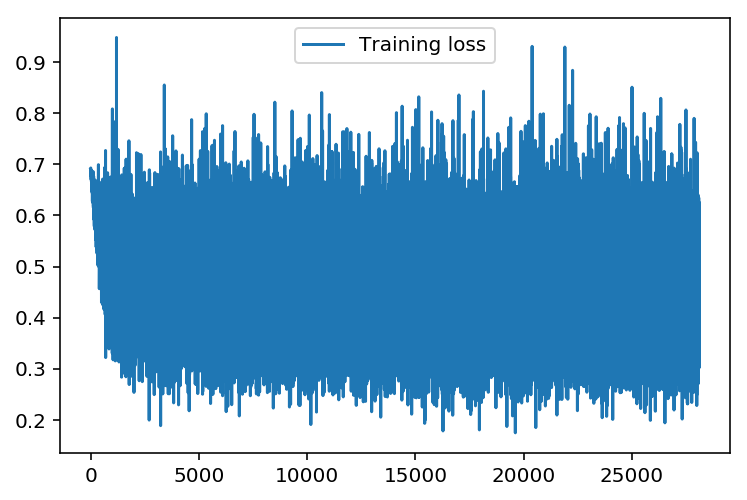

In [65]:
plt.plot(losses['train'], label='Training loss')
plt.legend()
_ = plt.ylim()

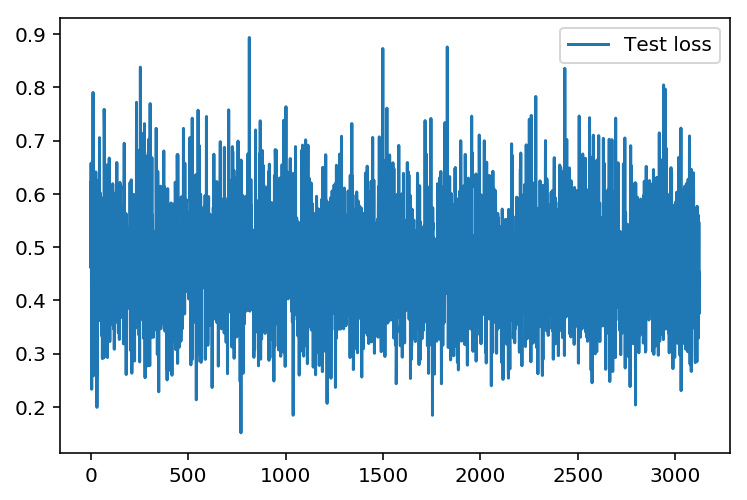

In [66]:
plt.plot(losses['test'], label='Test loss')
plt.legend()
_ = plt.ylim()

## 使用测试数据进行测试

In [68]:
ffm_test_out_path = './te_ffm.out.logit'
fm_test_out_path = './te.fm.logits'
test_path = './data/test.txt'

ffm_test = pd.read_csv(ffm_test_out_path, header=None)    
ffm_test = ffm_test[0].values

fm_test = pd.read_csv(fm_test_out_path, header=None)    
fm_test = fm_test[0].values

test_data = pd.read_csv(test_path, header=None)    
test_data = test_data.values

pred_test_X = np.concatenate((ffm_test.reshape(-1, 1), fm_test.reshape(-1, 1), test_data), 1)

# pred_test_X = cc_test[:,0:-1]

In [69]:
save_params_with_name((pred_test_X), "pred_test_X")

In [ ]:
pred_test_X = load_params_with_name("pred_test_X")

In [70]:
len(pred_test_X)

1000000

In [71]:
def get_tensors(loaded_graph):

    dense_input = loaded_graph.get_tensor_by_name("dense_input:0")
    sparse_input = loaded_graph.get_tensor_by_name("sparse_input:0")
    FFM_input = loaded_graph.get_tensor_by_name("FFM_input:0")
    FM_input = loaded_graph.get_tensor_by_name("FM_input:0")
    pred = loaded_graph.get_tensor_by_name("inference/prediction:0")#
    
    targets = loaded_graph.get_tensor_by_name("targets:0")
    lr = loaded_graph.get_tensor_by_name("LearningRate:0")
    return dense_input, sparse_input, FFM_input, FM_input, targets, lr, pred

In [72]:
def predict_click(x, axis = 0):
    loaded_graph = tf.Graph()  #loaded_graph
    with tf.Session(graph=loaded_graph) as sess:  #train_graph
        # Load saved model
        loader = tf.train.import_meta_graph(load_dir + '.meta')
        loader.restore(sess, load_dir)
    
        # Get Tensors from loaded model
        dense_input, sparse_input, FFM_input, FM_input, __, _, pred = get_tensors(loaded_graph)  #loaded_graph
    
        feed = {
              dense_input: np.reshape(x.take([2,3,4,5,6,7,8,9,10,11,12,13,14],axis), [1 if axis == 0 else len(x.take([2,3,4,5,6,7,8,9,10,11,12,13,14],axis)), 13]),
              sparse_input: np.reshape(x.take([15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40],axis), [1 if axis == 0 else len(x.take([15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40],axis)), 26]),
              FFM_input: np.reshape(x.take(0,axis), [1 if axis == 0 else len(x.take(0,axis)), 1]),
              FM_input: np.reshape(x.take(1,axis), [1 if axis == 0 else len(x.take(0,axis)), 1])}
    
        # Get Prediction
        clicked = sess.run([pred], feed)  
#         print(np.array(clicked))
        return (np.int32(np.array(clicked) > 0.5))[0]

In [76]:
predict_click(pred_test_X[0])

array([[0]], dtype=int32)

In [77]:
predict_click(pred_test_X[:20], 1)

array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0]], dtype=int32)

In [84]:
def get_test_batches(Xs, batch_size):
    for start in range(0, len(Xs), batch_size):
        end = min(start + batch_size, len(Xs))
        yield Xs[start:end]

In [89]:
def predict_test(batch_size, axis = 1):
    loaded_graph = tf.Graph()  #loaded_graph
    with tf.Session(graph=loaded_graph) as sess:  #train_graph
        # Load saved model
        loader = tf.train.import_meta_graph(load_dir + '.meta')
        loader.restore(sess, load_dir)
    
        # Get Tensors from loaded model
        dense_input, sparse_input, FFM_input, FM_input, __, _, pred = get_tensors(loaded_graph)  #loaded_graph
        test_batches = get_test_batches(pred_test_X, batch_size)
        total_num = len(pred_test_X)
        
        pred_lst = []
        for batch_i in range(total_num // batch_size):
            x = next(test_batches)
                
            feed = {
                  dense_input: np.reshape(x.take([2,3,4,5,6,7,8,9,10,11,12,13,14],axis), [1 if axis == 0 else len(x.take([2,3,4,5,6,7,8,9,10,11,12,13,14],axis)), 13]),
                  sparse_input: np.reshape(x.take([15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40],axis), [1 if axis == 0 else len(x.take([15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40],axis)), 26]),
                  FFM_input: np.reshape(x.take(0,axis), [1 if axis == 0 else len(x.take(0,axis)), 1]),
                  FM_input: np.reshape(x.take(1,axis), [1 if axis == 0 else len(x.take(0,axis)), 1])}
    
            # Get Prediction
            clicked = sess.run([pred], feed)  
            pred_lst.append(clicked)
            if ((total_num // batch_size) + batch_i) % show_every_n_batches == 0:
                        print('Batch {:>4}/{}   mean click = {}'.format(
                            batch_i,
                            (total_num // batch_size),
                            np.mean(np.array(clicked))))
#         print(np.array(clicked))
        return pred_lst

In [91]:
pred_lst = predict_test(64)

Batch    0/15625   mean click = 0.23291435837745667
Batch   25/15625   mean click = 0.2441655397415161
Batch   50/15625   mean click = 0.20712077617645264
Batch   75/15625   mean click = 0.22837260365486145
Batch  100/15625   mean click = 0.23258405923843384
Batch  125/15625   mean click = 0.21670520305633545
Batch  150/15625   mean click = 0.17298942804336548
Batch  175/15625   mean click = 0.23729506134986877
Batch  200/15625   mean click = 0.2072361707687378
Batch  225/15625   mean click = 0.22949182987213135
Batch  250/15625   mean click = 0.191495880484581
Batch  275/15625   mean click = 0.19321107864379883
Batch  300/15625   mean click = 0.26005569100379944
Batch  325/15625   mean click = 0.2759130895137787
Batch  350/15625   mean click = 0.20853781700134277
Batch  375/15625   mean click = 0.21732787787914276
Batch  400/15625   mean click = 0.24034711718559265
Batch  425/15625   mean click = 0.23197221755981445
Batch  450/15625   mean click = 0.2815670669078827
Batch  475/15625  

Batch 4025/15625   mean click = 0.25718551874160767
Batch 4050/15625   mean click = 0.22358953952789307
Batch 4075/15625   mean click = 0.22339928150177002
Batch 4100/15625   mean click = 0.30588382482528687
Batch 4125/15625   mean click = 0.2960987091064453
Batch 4150/15625   mean click = 0.27914974093437195
Batch 4175/15625   mean click = 0.26086509227752686
Batch 4200/15625   mean click = 0.32542452216148376
Batch 4225/15625   mean click = 0.29780733585357666
Batch 4250/15625   mean click = 0.287104994058609
Batch 4275/15625   mean click = 0.23420193791389465
Batch 4300/15625   mean click = 0.3061618208885193
Batch 4325/15625   mean click = 0.2912747263908386
Batch 4350/15625   mean click = 0.29544275999069214
Batch 4375/15625   mean click = 0.32753801345825195
Batch 4400/15625   mean click = 0.3233729898929596
Batch 4425/15625   mean click = 0.3018587827682495
Batch 4450/15625   mean click = 0.33128368854522705
Batch 4475/15625   mean click = 0.2456045001745224
Batch 4500/15625   m

Batch 8075/15625   mean click = 0.2645380198955536
Batch 8100/15625   mean click = 0.24229785799980164
Batch 8125/15625   mean click = 0.2698376178741455
Batch 8150/15625   mean click = 0.2508085072040558
Batch 8175/15625   mean click = 0.30194994807243347
Batch 8200/15625   mean click = 0.27145373821258545
Batch 8225/15625   mean click = 0.2738555073738098
Batch 8250/15625   mean click = 0.3001673221588135
Batch 8275/15625   mean click = 0.26563286781311035
Batch 8300/15625   mean click = 0.2813803553581238
Batch 8325/15625   mean click = 0.24460750818252563
Batch 8350/15625   mean click = 0.24737372994422913
Batch 8375/15625   mean click = 0.3074081540107727
Batch 8400/15625   mean click = 0.2729794383049011
Batch 8425/15625   mean click = 0.2626821994781494
Batch 8450/15625   mean click = 0.22110632061958313
Batch 8475/15625   mean click = 0.21573123335838318
Batch 8500/15625   mean click = 0.2818642258644104
Batch 8525/15625   mean click = 0.2870376408100128
Batch 8550/15625   mean

Batch 12050/15625   mean click = 0.34219467639923096
Batch 12075/15625   mean click = 0.266782283782959
Batch 12100/15625   mean click = 0.2693360447883606
Batch 12125/15625   mean click = 0.2514916658401489
Batch 12150/15625   mean click = 0.25578930974006653
Batch 12175/15625   mean click = 0.2604748010635376
Batch 12200/15625   mean click = 0.29582804441452026
Batch 12225/15625   mean click = 0.24068963527679443
Batch 12250/15625   mean click = 0.29262226819992065
Batch 12275/15625   mean click = 0.26445308327674866
Batch 12300/15625   mean click = 0.25775599479675293
Batch 12325/15625   mean click = 0.27819424867630005
Batch 12350/15625   mean click = 0.28408730030059814
Batch 12375/15625   mean click = 0.27631819248199463
Batch 12400/15625   mean click = 0.2731817960739136
Batch 12425/15625   mean click = 0.22351673245429993
Batch 12450/15625   mean click = 0.26238077878952026
Batch 12475/15625   mean click = 0.32303160429000854
Batch 12500/15625   mean click = 0.2642633318901062


In [92]:
np.mean(pred_lst)

0.27048749

## 总结

以上就是点击率预估的完整过程，没有进行完整数据的训练，并且有很多超参可以调整，从只跑了一次epoch的结果来看，验证集上的LogLoss是0.46，其他数据都在75%~80%之间，这跟FFM、GBDT和FM网络训练的准确率差不多。

## 扩展阅读

 - [`Code for the 3rd place finish for Avazu Click-Through Rate Prediction`](https://github.com/infinitezxc/kaggle-avazu)
 - [`Kaggle ： Display Advertising Challenge( ctr 预估 )`](http://blog.csdn.net/hero_fantao/article/details/42747281)
 - [`用机器学习对CTR预估建模`](http://blog.csdn.net/JR_lu/article/details/54836968)
 - [`Beginner's Guide to Click-Through Rate Prediction with Logistic Regression`](https://turi.com/learn/gallery/notebooks/click_through_rate_prediction_intro.html)
 - [`2nd place solution for Avazu click-through rate prediction competition`](https://github.com/owenzhang/kaggle-avazu)
 - [`常见计算广告点击率预估算法总结`](https://zhuanlan.zhihu.com/p/29053940?group_id=916424345212342272)
 - [`3 Idiots' Approach for Display Advertising Challenge`](https://github.com/guestwalk/kaggle-2014-criteo)
 - [`Solution to the Outbrain Click Prediction competition`](https://github.com/alexeygrigorev/outbrain-click-prediction-kaggle)
 - [`Deep Interest Network for Click-Through Rate Prediction`](https://arxiv.org/abs/1706.06978)
 - [`Learning Piece-wise Linear Models from Large Scale Data for Ad Click Prediction`](https://arxiv.org/abs/1704.05194)
 - [`重磅！阿里妈妈首次公开自研CTR预估核心算法MLR`](https://mp.weixin.qq.com/s/MtnHYmPVoDAid9SNHnlzUw)
 - [`阿里盖坤团队提出深度兴趣网络，更懂用户什么时候会剁手`](http://www.sohu.com/a/152084716_114877)
 - [`深入FFM原理与实践`](https://tech.meituan.com/deep-understanding-of-ffm-principles-and-practices.html)

## 今天的分享就到这里，就酱~